In [ ]:
!wget -N http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz -O ./datasets/facades.tar.gz
!mkdir -p ./datasets/facades/
!tar zxvf ./datasets/facades.tar.gz -C ./datasets
!rm ./datasets/facades.tar.gz

In [12]:
import os
from datetime import datetime
from collections import defaultdict
from PIL import Image
import numpy as np
import cv2 as cv
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.image.fid import FrechetInceptionDistance 
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter

os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [13]:
class GlobalConfig:
    batch_size: int = 80
    num_workers: int = 8
    n_epochs: int = 100
    train_part: float = 0.9
    wandb_project = 'dl-bhw3-cyclegan'
    facades_path = './datasets/facades/'
    imdb_path = './datasets/imdb/'
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [19]:
class AlignedDataset(Dataset):
    def __init__(self, path):
        self.path = path
        self.filenames = os.listdir(self.path)
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
    def __len__(self):
        return len(self.filenames)
    def __getitem__(self, index):
        loaded = Image.open(os.path.join(self.path, self.filenames[index])).convert('RGB')
        width, height = loaded.size[0] // 2, loaded.size[1]
        img_B, img_A = loaded.crop((0, 0, width, height)), loaded.crop((width, 0, width * 2, height))
        return {
            'A': self.transform(img_A),
            'B': self.transform(img_B),
        }

class AlignedDatasetDecolor(Dataset):
    def __init__(self, path):
        self.path = path
        self.filenames = os.listdir(self.path)
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        self.gs_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(0.5, 0.5),
        ])
    def __len__(self):
        return len(self.filenames)
    def __getitem__(self, index):
        img_B = Image.open(os.path.join(self.path, self.filenames[index])).convert('RGB')
        img_A = img_B.convert('L')
        # img_A = transforms.ToPILImage()(cv.Canny(np.array(img_B), 100, 200))
        return {
            'A': self.gs_transform(img_A),
            'B': self.transform(img_B),
        }

In [49]:
def get_ds_dl(dir, **kwargs):
    ds = AlignedDataset(dir)
    return (
        ds,
        DataLoader(ds, batch_size=GlobalConfig.batch_size, num_workers=GlobalConfig.num_workers, pin_memory=True, **kwargs)
    )

def get_data(root):
    train_ds, train_dl = get_ds_dl(os.path.join(root, 'train'), shuffle=True)
    val_ds, val_dl = get_ds_dl(os.path.join(root, 'val'))
    test_ds, test_dl = get_ds_dl(os.path.join(root, 'test'))
    return (
        train_ds, val_ds, test_ds,
        train_dl, val_dl, test_dl
    )
# -------
def get_data_color(root):
    ds = AlignedDatasetDecolor(root)
    total_count = len(ds)
    train_count = int(total_count * GlobalConfig.train_part)

    train_ds, val_ds = random_split(
        ds, lengths=[train_count, total_count - train_count],
        generator=torch.Generator().manual_seed(42)
    )
    train_dl = DataLoader(train_ds, batch_size=GlobalConfig.batch_size, num_workers=GlobalConfig.num_workers, pin_memory=True, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=GlobalConfig.batch_size, num_workers=GlobalConfig.num_workers, pin_memory=True)
    
    return (
        train_ds, val_ds, None,
        train_dl, val_dl, None
    )

In [50]:
# inspired by https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix
class Discriminator(nn.Module):
    def __init__(self, input_ch, n_layers=3):
        super().__init__()
        
        cur_ch = 64

        layers = [
            nn.Conv2d(input_ch, cur_ch, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True),            
        ]

        for idx in range(1, n_layers):
            prev_ch, cur_ch = cur_ch, cur_ch * 2
            layers += [
                nn.Conv2d(prev_ch, cur_ch, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(cur_ch),
                nn.LeakyReLU(0.2, True)
            ]
        
        prev_ch, cur_ch = cur_ch, cur_ch * 2
        layers += [
            nn.Conv2d(prev_ch, cur_ch, kernel_size=4, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(cur_ch),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(cur_ch, 1, kernel_size=4, stride=1, padding=1),
        ]

        self.model = nn.Sequential(*layers)
    
    def forward(self, images):
        return self.model(images)

class ResnetBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(ch, ch, kernel_size=3, padding=1, padding_mode='reflect', bias=False),
            nn.BatchNorm2d(ch),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Conv2d(ch, ch, kernel_size=3, padding=1, padding_mode='reflect', bias=False),
        )

    def forward(self, x):
        return x + self.model(x)

class Generator(nn.Module):
    def __init__(self, input_ch, output_ch, n_blocks=6):
        super().__init__()

        prev_ch = cur_ch = 64
        layers = [
            nn.Conv2d(input_ch, cur_ch, kernel_size=7, padding=3, padding_mode='reflect', bias=False),
            nn.BatchNorm2d(cur_ch),
            nn.ReLU(True),
        ]

        for i in range(2):
            prev_ch, cur_ch = cur_ch, cur_ch * 2
            layers += [
                nn.Conv2d(prev_ch, cur_ch, kernel_size=3, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(cur_ch),
                nn.ReLU(True)
            ]

        layers += [ResnetBlock(cur_ch) for _ in range(n_blocks)]

        for i in range(2):
            prev_ch, cur_ch = cur_ch, cur_ch // 2
            layers += [
                nn.ConvTranspose2d(prev_ch, cur_ch, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
                nn.BatchNorm2d(cur_ch),
                nn.ReLU(True),
            ]
        layers += [
            nn.Conv2d(cur_ch, output_ch, kernel_size=7, padding=3, padding_mode='reflect'),
            nn.Tanh(),
        ]

        self.model = nn.Sequential(*layers)

    def forward(self, images):
        return self.model(images)


class UnetSkipBlock(nn.Module):
    def __init__(
        self, outer_ch, inner_ch, input_ch=None,
        submodule=None, outermost=False, innermost=False
    ):
        super(UnetSkipBlock, self).__init__()
        
        self.outermost = outermost
        input_ch = input_ch or outer_ch

        if outermost:
            model = [
                nn.Conv2d(input_ch, inner_ch, kernel_size=4, stride=2, padding=1, bias=False),
                submodule,
                nn.ReLU(True),
                nn.ConvTranspose2d(inner_ch * 2, outer_ch, kernel_size=4, stride=2, padding=1),
                nn.Tanh(),
            ]
        elif innermost:
            model = [
                nn.LeakyReLU(0.2, True),
                nn.Conv2d(input_ch, inner_ch, kernel_size=4, stride=2, padding=1, bias=False),
                nn.ReLU(True),
                nn.ConvTranspose2d(inner_ch, outer_ch, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(outer_ch),
            ]
        else:
            model = [
                nn.LeakyReLU(0.2, True),
                nn.Conv2d(input_ch, inner_ch, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(inner_ch),
                submodule,
                nn.ReLU(True),
                nn.ConvTranspose2d(inner_ch * 2, outer_ch, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(outer_ch),
                nn.Dropout(0.5),
            ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], dim=1)


class UNetGenerator(nn.Module):
    def __init__(self, input_ch, output_ch, n_blocks):
        super().__init__()
        inner_ch = 64
        
        # innermost block, no submodule
        unet_block = UnetSkipBlock(inner_ch * 8, inner_ch * 8, input_ch=None, submodule=None, innermost=True)
        
        # deep blocks (closest to innermost)
        for i in range(n_blocks - 5):
            unet_block = UnetSkipBlock(inner_ch * 8, inner_ch * 8, input_ch=None, submodule=unet_block)
        
        unet_block = UnetSkipBlock(inner_ch * 4, inner_ch * 8, input_ch=None, submodule=unet_block)
        unet_block = UnetSkipBlock(inner_ch * 2, inner_ch * 4, input_ch=None, submodule=unet_block)
        unet_block = UnetSkipBlock(inner_ch, inner_ch * 2, input_ch=None, submodule=unet_block)
        
        self.model = UnetSkipBlock(output_ch, inner_ch, input_ch=input_ch, submodule=unet_block, outermost=True)

    def forward(self, input):
        return self.model(input)

In [51]:
def gan_loss(discriminator_out, value):
    true_out = torch.empty_like(discriminator_out).fill_(value)
    # return F.binary_cross_entropy(discriminator_out, true_out)
    return F.binary_cross_entropy_with_logits(discriminator_out, true_out)

# inspired by https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix
class Pix2PixModel(nn.Module):
    def __init__(self, input_ch, output_ch, n_blocks=8):
        super().__init__()
        # self.generator = Generator(3, 3)
        self.generator = UNetGenerator(input_ch, output_ch, n_blocks)
        self.discriminator = Discriminator(input_ch+output_ch, 3)

        # self.goptimizer = torch.optim.Adam(self.generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
        # self.doptimizer = torch.optim.Adam(self.discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
        self.goptimizer = torch.optim.AdamW(self.generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
        self.doptimizer = torch.optim.AdamW(self.discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
    
    def set_input(self, batch):
        self.real_A = batch['A'].to(GlobalConfig.device)
        self.real_B = batch['B'].to(GlobalConfig.device)

    def forward(self):
        self.fake_B = self.generator(self.real_A)
    
    def backward_discriminator(self):
        # Fake
        fake_AB = torch.cat((self.real_A, self.fake_B), dim=1)
        pred_fake = self.discriminator(fake_AB.detach())
        self.loss_discriminator_fake = gan_loss(pred_fake, 0.0)
        # Real
        real_AB = torch.cat((self.real_A, self.real_B), dim=1)
        pred_real = self.discriminator(real_AB)
        self.loss_discriminator_real = gan_loss(pred_real, 1.0)
        
        self.loss_discriminator = (self.loss_discriminator_fake + self.loss_discriminator_real) * 0.5
        self.loss_discriminator.backward()

    def backward_generator(self):
        # GAN Loss
        fake_AB = torch.cat((self.real_A, self.fake_B), dim=1)
        pred_fake = self.discriminator(fake_AB)
        self.loss_generator_gan = gan_loss(pred_fake, 1.0)

        # L1 Loss
        self.loss_generator_l1 = F.l1_loss(self.fake_B, self.real_B)
        # self.loss_generator_l1.backward()
        self.loss_generator = self.loss_generator_gan + 100.0 * self.loss_generator_l1
        self.loss_generator.backward()

    def get_all_losses(self):
        names = [
            'loss_generator',
            'loss_generator_l1',
            'loss_generator_gan',
            'loss_discriminator',
            'loss_discriminator_real',
            'loss_discriminator_fake',
        ]
        return {n: getattr(self, n) for n in names}

    def optimize_parameters(self):
        self.forward()
        # update discriminator
        self.set_requires_grad(self.discriminator, True)
        self.doptimizer.zero_grad()
        self.backward_discriminator()
        self.doptimizer.step()
        # update generator
        self.set_requires_grad(self.discriminator, False)
        self.goptimizer.zero_grad()
        self.backward_generator()
        self.goptimizer.step() 

    def set_requires_grad(self, model, value):
        for p in model.parameters():
            p.requires_grad = value 

In [52]:
def train_epoch(model, train_dl, epoch=-1, tbwriter: SummaryWriter = None, step = None):
    model.train()

    total_samples = 0
    accumulated_losses = defaultdict(float)
    
    for idx, batch in (enumerate(train_dl)):
        bsz = batch['A'].size(0)

        model.set_input(batch)
        model.optimize_parameters()

        total_samples += bsz
        cur_losses = model.get_all_losses()
        for n, ls in cur_losses.items():
            accumulated_losses[n] += ls.item()
        
        if tbwriter is not None:
            global_step = step + idx

            for n, acc_ls in accumulated_losses.items():
                tbwriter.add_scalar(f'loss/{n[5:]}', acc_ls / total_samples, global_step)

    if tbwriter is not None:
        global_step = step + idx
        rA, rB, fB = model.real_A[0] * 0.5 + 0.5, model.real_B[0] * 0.5 + 0.5, model.fake_B[0] * 0.5 + 0.5
        # print(rA.size(), rB.size(), fB.size())
        if rA.size(0) == 1:  # grayscale
            rA = rA.repeat(3, 1, 1)
        combination = torch.cat((rA, fB, rB), dim=2)
        tbwriter.add_image('all-in-one', combination, global_step)
        # tbwriter.add_image('real_A', rA, global_step)
        # tbwriter.add_image('real_B', rB, global_step)
        # tbwriter.add_image('fake_B', fB, global_step)

def validation(model, val_dl, epoch=-1, tbwriter: SummaryWriter = None, step = None):
    model.eval()
    
    with torch.no_grad():
        fid = FrechetInceptionDistance(normalize=True)
        for batch in val_dl:
            model.set_input(batch)
            model.forward()
            fid.update(model.real_B.cpu() * 0.5 + 0.5, real=True)
            fid.update(model.fake_B.cpu() * 0.5 + 0.5, real=False)
        fid_score = fid.compute()

        if tbwriter is not None:
            tbwriter.add_scalar('validation/fid', fid_score, step)
            # pick 3 images from last batch
            for idx, img_idx in enumerate(np.random.choice(model.real_A.size(0), size=3, replace=False)):
                rA, rB, fB = model.real_A[img_idx] * 0.5 + 0.5, model.real_B[img_idx] * 0.5 + 0.5, model.fake_B[img_idx] * 0.5 + 0.5
                if rA.size(0) == 1:  # grayscale
                    rA = rA.repeat(3, 1, 1)
                combination = torch.cat((rA, fB, rB), dim=2)
                tbwriter.add_image(f'validation/all-in-one/{idx}', combination, step)
    
    return fid_score

In [54]:
train_ds, val_ds, test_ds, train_dl, val_dl, test_dl = get_data_color(GlobalConfig.imdb_path)

model = Pix2PixModel(1, 3, 4).to(device=GlobalConfig.device)

# tbwriter = None
tbwriter = SummaryWriter(f'./runs/{datetime.now().strftime("%b%d_%H-%M-%S")}')

In [ ]:
for epoch in tqdm(range(GlobalConfig.n_epochs+100, GlobalConfig.n_epochs+200)):
    train_epoch(model, train_dl, epoch=epoch, tbwriter=tbwriter, step=len(train_dl) * epoch)
    if epoch % 5 == 0:
        validation(model, val_dl, epoch=epoch, tbwriter=tbwriter, step=len(train_dl) * epoch)

In [30]:
torch.save(model, 'Pix2Pix-full_model-unet-discriminator-imdb-color-ep300.ckpt')

In [57]:
train_ds, val_ds, test_ds, train_dl, val_dl, test_dl = get_data(GlobalConfig.facades_path)
validation(torch.load('Pix2Pix-full_model-unet-discriminator-Dec15_03-13-32-m2.ckpt'), val_dl)

tensor(194.0958)

In [56]:
train_ds, val_ds, test_ds, train_dl, val_dl, test_dl = get_data_color(GlobalConfig.imdb_path)
validation(torch.load('Pix2Pix-full_model-unet-discriminator-imdb-color-ep300.ckpt'), val_dl)

tensor(108.7445)

визуализация

In [34]:
import matplotlib.pyplot as plt

def plot_images(model, item, axis):
    model.eval()
    with torch.no_grad():
        batch = {'A': item['A'].unsqueeze(0), 'B': item['B'].unsqueeze(0)}
        model.set_input(batch)
        model.forward()
        rA, rB, fB = model.real_A[0] * 0.5 + 0.5, model.real_B[0] * 0.5 + 0.5, model.fake_B[0] * 0.5 + 0.5
        if rA.size(0) == 1:  # grayscale
            rA = rA.repeat(3, 1, 1)
        combination = torch.cat((rA, fB, rB), dim=2)
        axis.imshow(combination.permute(1, 2, 0).cpu().numpy())

колоризация

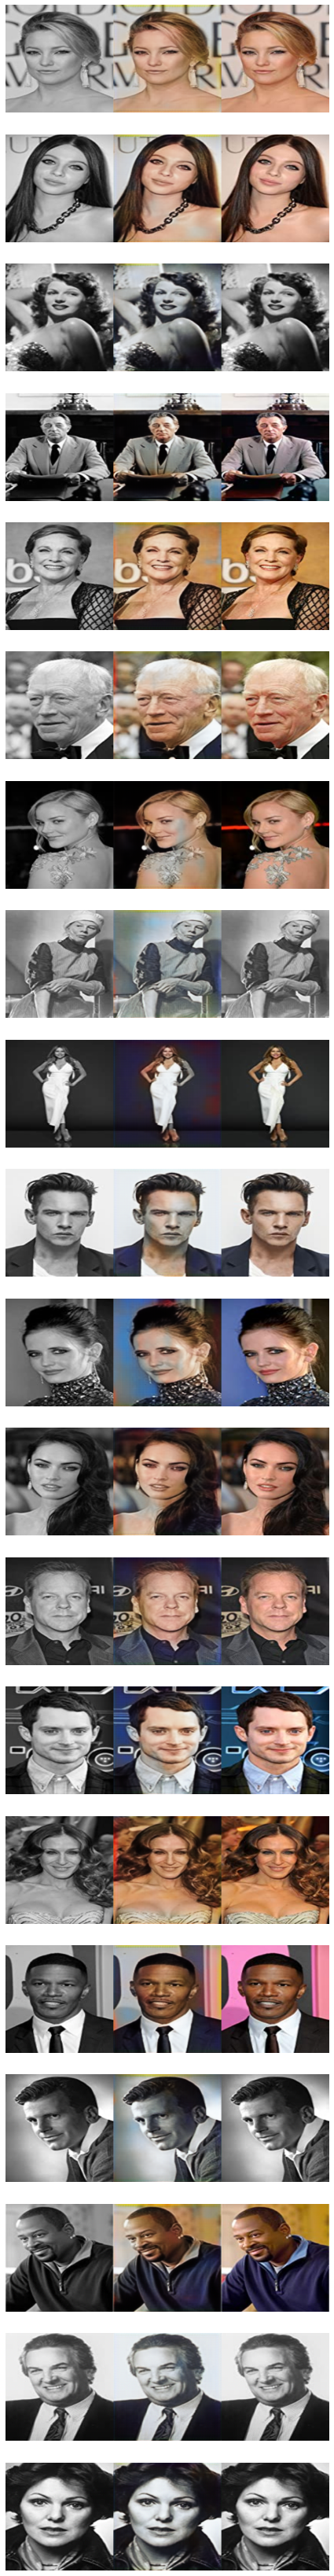

In [37]:
# plt.axis('off')
# plt.figure(figsize=(20, 40))
fig, axes = plt.subplots(20, 1, figsize=(16, 60))
for idx in range(20):
    axes[idx].axis('off')
    plot_images(model, train_ds[10+idx], axes[idx])

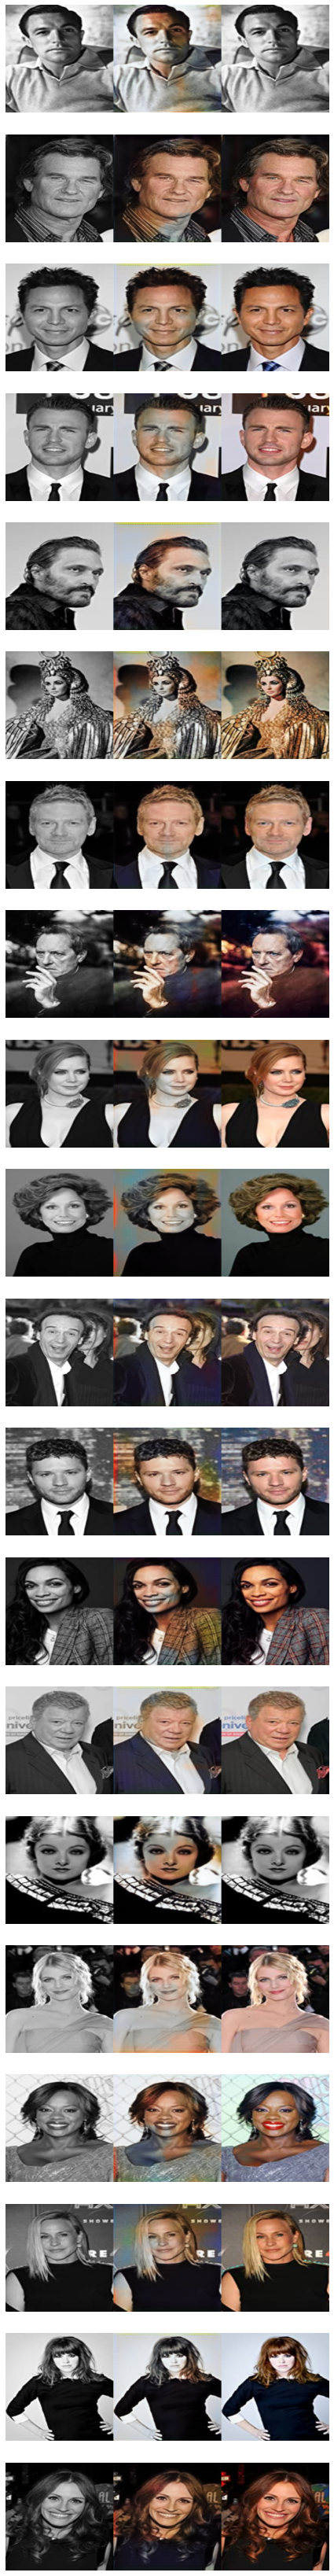

In [39]:
fig, axes = plt.subplots(20, 1, figsize=(16, 60))
for idx in range(20):
    axes[idx].axis('off')
    plot_images(model, val_ds[60+idx], axes[idx])

фасады

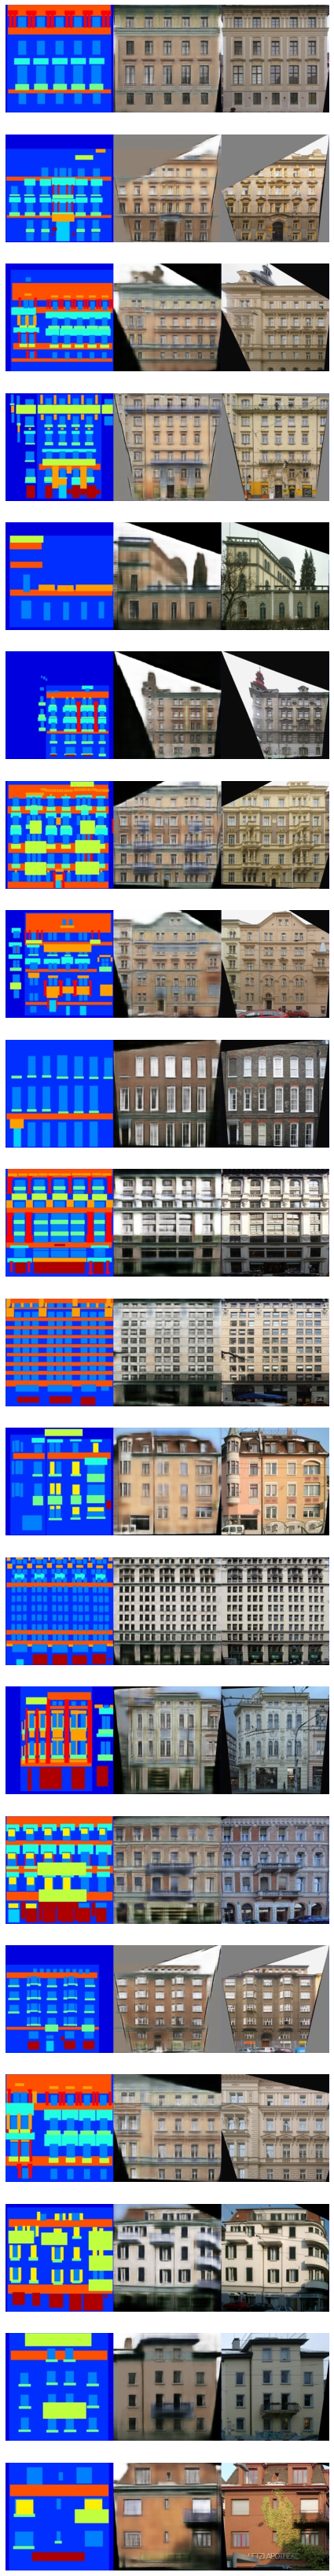

In [70]:
# plt.axis('off')
# plt.figure(figsize=(20, 40))
fig, axes = plt.subplots(20, 1, figsize=(16, 60))
for idx in range(20):
    axes[idx].axis('off')
    plot_images(model, train_ds[10+idx], axes[idx])

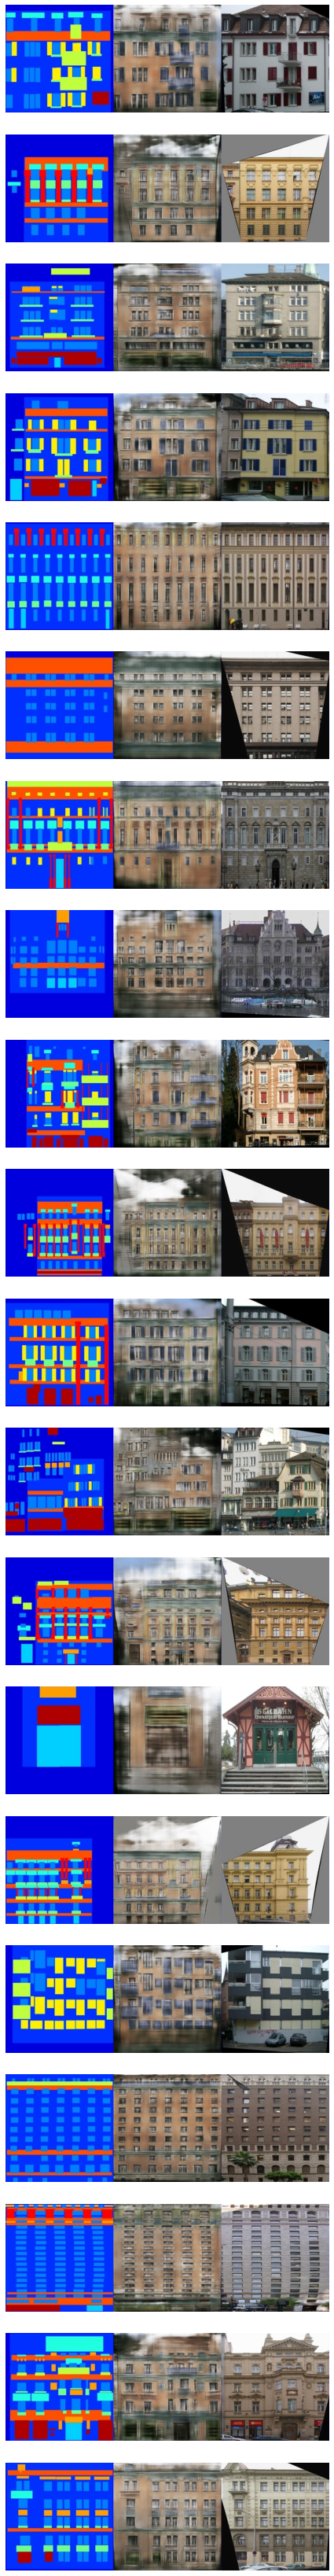

In [73]:
fig, axes = plt.subplots(20, 1, figsize=(16, 60))
for idx in range(20):
    axes[idx].axis('off')
    plot_images(model, test_ds[60+idx], axes[idx])